# Loading necessary libraries

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from IPython.display import clear_output

# Loading and preprocessing the training and validation dataset

In [1]:
# Paths
img_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
partition_file = '/kaggle/input/celeba-dataset/list_eval_partition.csv'

# Load partition information
partition_df = pd.read_csv(partition_file)

# Mapping partitions
partition_df.columns = ['image_id', 'partition']

# Create lists of file paths
train_files = partition_df[(partition_df['partition'] == 0)]['image_id'].tolist()
val_files = partition_df[(partition_df['partition'] == 2)]['image_id'].tolist()

# Add directory prefix to image IDs
train_files = [os.path.join(img_dir, img_id) for img_id in train_files]
val_files = [os.path.join(img_dir, img_id) for img_id in val_files]

# Function to load and preprocess images before preparing the dataset
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32 in [0, 1]
    img = tf.image.resize(img, [64, 64])  # Resize to the desired size
    return img

batch_size = 32

# Creating TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

2025-06-15 21:02:47.342094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750021367.770579      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750021367.905582      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750021388.081849      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750021388.082563      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

# Loading a previously trained and saved autoencoder (to save time and skip the training process)

In [2]:
# Loading a saved autoencoder
autoencoder = load_model('/kaggle/input/autoencoder-32-10/autoencoder_32_10.h5')
encoder = load_model('/kaggle/input/autoencoder-32-10/autoencoder_encoder_32_10.h5')
decoder = load_model('/kaggle/input/autoencoder-32-10/autoencoder_decoder_32_10.h5')

encoder.summary()
decoder.summary()
autoencoder.summary()

# Storing the weights of the first layer of the decoder for usage during rotation of latent space
W, bias = decoder.layers[1].get_weights()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,447,136 (5.52 MB)

 Trainable params: 1,447,072 (5.52 MB)

 Non-trainable params: 64 (256.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_8CLONE (InputLayer)     │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,699 (772.26 KB)

 Trainable params: 197,699 (772.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 32)                  │       1,447,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 3)           │         197,699 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,644,837 (6.27 MB)

 Trainable params: 1,644,771 (6.27 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 2 (12.00 B)

# Define the autoencoder (Not required if a previously trained and saved Autoencoder is loaded before)

In [ ]:
# Encoder
input_img = layers.Input(shape=(64,64,3))
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', strides=(2, 2))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Flatten()(x) 
x = layers.Dense(256, activation='relu')(x)
encoded = layers.Dense(128, activation='relu')(x)
encoder = Model(input_img, encoded)
encoder.summary()


# Decoder
x = layers.Dense(4 * 4 * 128, activation='relu')(encoded)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)
decoder.summary()

# Full Autoencoder
autoencoder_input = input_img
autoencoder_output = decoder(encoder(autoencoder_input))

# Compiling the Autoencoder
autoencoder = Model(autoencoder_input, autoencoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Training and saving the autoencoder (Not required if a previously trained and saved autoencoder is loaded before)

In [ ]:
# Setting up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the Autoencoder
history = autoencoder.fit(train_dataset,
                          epochs=10,
                          validation_data= val_dataset,
                          callbacks = [early_stopping]
                         )

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

# Saving the trained autoencoder for future use
autoencoder.save('/kaggle/working/autoencoder_32_10.keras')
encoder.save('/kaggle/working/autoencoder_encoder_32_10.keras')
decoder.save('/kaggle/working/autoencoder_decoder_32_10.keras')

# Evaluate and Visualize

I0000 00:00:1750021418.787117      94 service.cc:148] XLA service 0x7f3a9c009870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750021418.788788      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750021418.788809      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750021419.017547      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


I0000 00:00:1750021421.774596      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


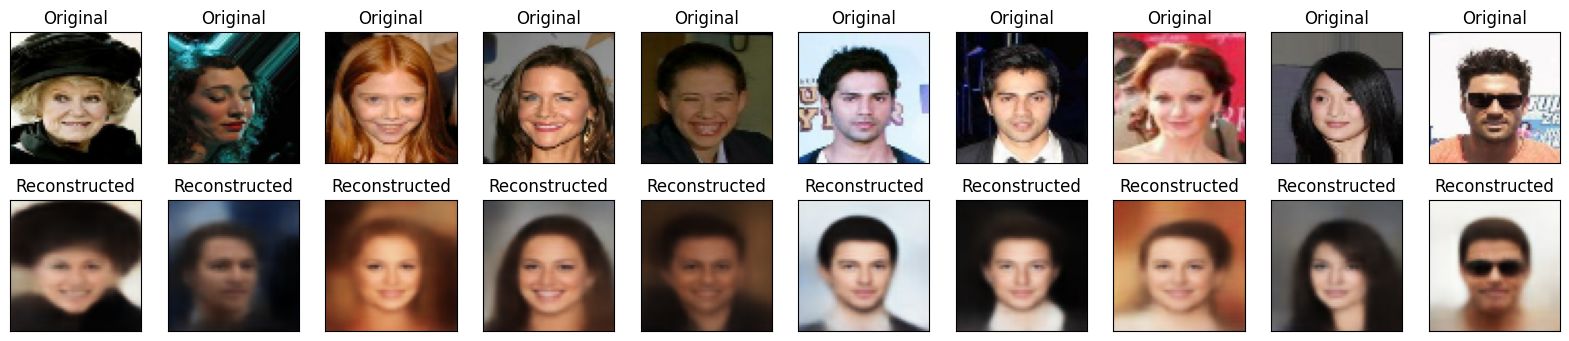

In [3]:
all_original_images = []
all_reconstructed_images = []

for images in val_dataset.take(10):
    # Generate reconstructions
    reconstructed_images = autoencoder.predict(images)
    
    # Collect images and their reconstructions
    all_original_images.extend(images.numpy())
    all_reconstructed_images.extend(reconstructed_images)


# Function to display the original and reconstructed images  
def show_reconstructed_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(original_images))):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig('autoencoder_ip_op.png')
    plt.show()

show_reconstructed_images(all_original_images[:10], all_reconstructed_images[:10])

# Extracting the latent space representation

In [4]:
latent_train= encoder.predict(train_dataset)
latent_val = encoder.predict(val_dataset)

5086/5086 ━━━━━━━━━━━━━━━━━━━━ 387s 76ms/step
623/623 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step


# Loading attribute data

In [5]:
attributes_file = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'

df_attributes = pd.read_csv(attributes_file)
df = pd.merge(df_attributes, partition_df, left_on='image_id', right_on='image_id')

# Applying factor rotation to the latent space representation

In [6]:
selected_attributes = ['Bald', 'Black_Hair', 'Pale_Skin', 'Smiling', 'Eyeglasses'] 
Z_train, Z_val = latent_train, latent_val
beta_list = []
y_train_attr_list, y_val_attr_list = [],[]

# Loop over each selected attribute name
for attr in selected_attributes:
    # Extract training and validation labels
    y_train_attr = ((df[(df['partition'] == 0)][attr][:162752] + 1)/2).astype(int)
    y_val_attr = ((df[(df['partition'] == 2)][attr][:19936] + 1)/2).astype(int)

    # Train logistic regression
    logistic_model = LogisticRegression()
    logistic_model.fit(latent_train, y_train_attr)

    # Normalize and store the coefficient vector
    beta = logistic_model.coef_.flatten()
    beta /= np.linalg.norm(beta)
    beta_list.append(beta)
    y_train_attr_list.append(y_train_attr)
    y_val_attr_list.append(y_val_attr)

# Construct the custom basis matrix B
I_n = np.eye(latent_train.shape[1])
k = len(beta_list)  # number of selected attributes
B = np.column_stack(beta_list + [I_n[:, i] for i in range(k, I_n.shape[1])])  # Fill remaining dimensions

# Perform QR decomposition
Q, _ = np.linalg.qr(B)
R = Q  # The orthogonal rotation matrix

#Oblique rotation matrix
R_prime = np.column_stack(beta_list + [Q[:, i] for i in range(k, Q.shape[1])])

# Apply the rotation
Z_train_orth_rotated = Z_train @ R
Z_val_orth_rotated = Z_val @ R

Z_train_obl_rotated = Z_train @ R_prime
Z_val_obl_rotated = Z_val @ R_prime

# Disentanglement metrics

In [7]:
def predictability_matrix(Z, attrs):
    """
    Z: latent space (n_samples, d)
    attrs: binary attributes (n_samples, k)
    Returns: (k, d) matrix of ROC AUC scores
    """
    k = attrs.shape[1]
    D = Z.shape[1]
    scores = np.zeros((k, D))
    for i in range(k):
        attr = attrs[:, i]
        for j in range(D):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            scores[i, j] = roc_auc_score(attr, prob)
    return scores


def compute_sap(Z, attrs):
    """
    Z: latent space (n_samples, d)
    attrs: binary attributes (n_samples, k)
    Returns: average SAP score
    """
    k = attrs.shape[1]
    D = Z.shape[1]
    sap_values = []
    for i in range(k):
        attr = attrs[:, i]
        aucs = []
        for j in range(D):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            auc = roc_auc_score(attr, prob)
            aucs.append(auc)
        aucs = np.sort(aucs)[::-1]
        sap_values.append(aucs[0] - aucs[1])
    return np.mean(sap_values)

def compute_mutual_info_matrix(Z, attrs):
    """
    Z: latent space (n_samples, d)
    attrs: binary attributes (n_samples, k)
    Returns: (k, d) matrix of MI scores
    """
    k = attrs.shape[1]
    D = Z.shape[1]
    mi_scores = np.zeros((k, D))
    for i in range(k):
        mi = mutual_info_classif(Z, attrs[:, i], discrete_features=False)
        mi_scores[i] = mi
    return mi_scores


def compute_modularity(predict_matrix):
    """
    predict_matrix: shape (k, d), e.g. from predictability_matrix
    Returns: modularity score [0, 1]
    """
    k, d = predict_matrix.shape
    modularity = 0.0
    for j in range(d):
        col = predict_matrix[:, j]
        col_norm = col / (np.sum(col) + 1e-8)
        modularity += 1.0 - (np.sum(col_norm ** 2) - np.max(col_norm) ** 2)
    return modularity / d

# Evaluate disentanglement metrics

In [8]:
k = len(selected_attributes)
attrs = np.array(y_train_attr_list).T

# Before and after rotation
print("Predictability Matrix")
scores_orig = predictability_matrix(Z_train[:,:k], attrs)
print("Before rotation")
print(scores_orig)
scores_orth_rot = predictability_matrix(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(scores_orth_rot)
scores_obl_rot = predictability_matrix(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(scores_obl_rot)
print("\n")

mod_orig = compute_modularity(scores_orig)
print(f"Modularity before rotation: {mod_orig}")
mod_orth_rot = compute_modularity(scores_orth_rot)
print(f"Modularity after orthogonal rotation:  {mod_orth_rot}")
mod_obl_rot = compute_modularity(scores_obl_rot)
print(f"Modularity after oblique rotation:  {mod_obl_rot}")
print("\n")

print("SAP score")
sap_orig = compute_sap(Z_train[:,:k], attrs)
print("Before rotation")
print(sap_orig)
sap_orth_rot = compute_sap(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(sap_orth_rot)
sap_obl_rot = compute_sap(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(sap_obl_rot)
print("\n")

print("Mutual info matrix")
mig_orig = compute_mutual_info_matrix(Z_train[:,:k], attrs)
print("Before rotation")
print(mig_orig)
mig_orth_rot = compute_mutual_info_matrix(Z_train_orth_rotated[:,:k], attrs)
print("After orthogonal rotation")
print(mig_orth_rot)
mig_obl_rot = compute_mutual_info_matrix(Z_train_obl_rotated[:,:k], attrs)
print("After oblique rotation")
print(mig_obl_rot)

Predictability Matrix
Before rotation
[[0.51980557 0.54574803 0.55112062 0.57916806 0.5121381 ]
 [0.53567904 0.55939639 0.53648604 0.59879542 0.62580141]
 [0.50930638 0.55491332 0.62877626 0.70432911 0.56355425]
 [0.55044003 0.53030165 0.50936261 0.53849083 0.50048508]
 [0.54489159 0.5288452  0.50871855 0.55131965 0.51212909]]
After orthogonal rotation
[[0.90991433 0.60486328 0.50036738 0.49939964 0.61632242]
 [0.61270169 0.82844989 0.50791287 0.52838329 0.51853094]
 [0.6027551  0.59156441 0.90243546 0.5689749  0.52498645]
 [0.52473571 0.51140805 0.57427321 0.79637925 0.56595946]
 [0.73342042 0.52190533 0.62442786 0.62281715 0.74336821]]
After oblique rotation
[[0.90991433 0.67508801 0.58050987 0.54058898 0.80161429]
 [0.61270169 0.83343059 0.5636034  0.51064904 0.50219968]
 [0.6027551  0.56748316 0.91696594 0.62199323 0.72017403]
 [0.52473571 0.50677986 0.55935363 0.83260981 0.64525725]
 [0.73342042 0.5174612  0.67653437 0.64770742 0.84785199]]


Modularity before rotation: 0.84846294

# Latent space traversal (Orthogonal rotation)

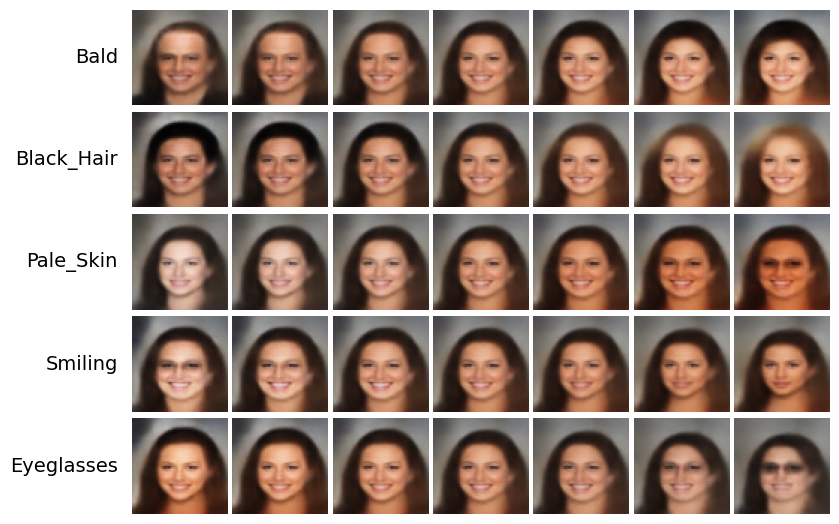

In [12]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

# Latent traversal setup
traversal_range = 3.5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Create subplots
fig, axes = plt.subplots(5, steps, figsize=(steps * 1.2, 6))

fig.subplots_adjust(
    left=0.15,   # reserve space for y-axis labels
    right=0.98,
    top=0.9,
    bottom=0.05,
    wspace=0.05,  # thin vertical strips
    hspace=0.01   # thin horizontal strips
)

for dim in range(5):
    for i, val in enumerate(linspace):
        z = Z_val_orth_rotated[3, :].copy()
        z[dim] += val

        # Decode
        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        # Plot
        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(
                selected_attributes[dim].replace('_', '\n'),
                fontsize=9,
                rotation=0,
                labelpad=15,
                va='center'
            )
for row in range(5):
    ax = axes[row, 0]  # First image in the row
    ax.text(
        -0.15, 0.5,                               
        selected_attributes[row], 
        va='center', ha='right', 
        fontsize=14, transform=ax.transAxes
    )

# Title
plt.savefig('cae_latent_space_traversal_celeba_orth.jpg')
plt.show()

# Latent space traversal (Oblique rotation)

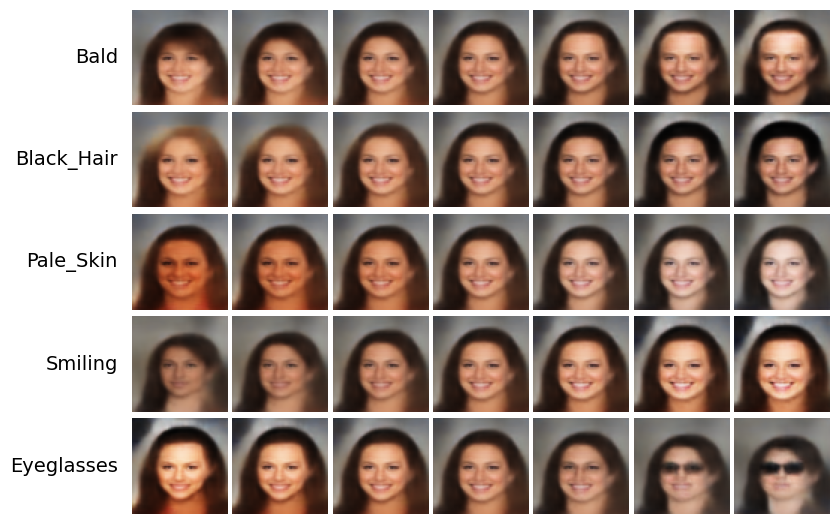

In [11]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

# Latent traversal setup
traversal_range = 3.5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Create subplots
fig, axes = plt.subplots(5, steps, figsize=(steps * 1.2, 6))

fig.subplots_adjust(
    left=0.15,   # reserve space for y-axis labels
    right=0.98,
    top=0.9,
    bottom=0.05,
    wspace=0.05,  # thin vertical strips
    hspace=0.01   # thin horizontal strips
)

for dim in range(5):
    for i, val in enumerate(linspace):
        z = Z_val_obl_rotated[3, :].copy()
        z[dim] += val

        # Decode
        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        # Plot
        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(
                selected_attributes[dim].replace('_', '\n'),
                fontsize=9,
                rotation=0,
                labelpad=15,
                va='center'
            )
for row in range(5):
    ax = axes[row, 0]  # First image in the row
    ax.text(
        -0.15, 0.5,                               
        selected_attributes[row], 
        va='center', ha='right', 
        fontsize=14, transform=ax.transAxes
    )

# Title
plt.savefig('cae_latent_space_traversal_celeba_obl.jpg')
plt.show()

# Correlation plot between latent space and selected attributes before and after rotation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


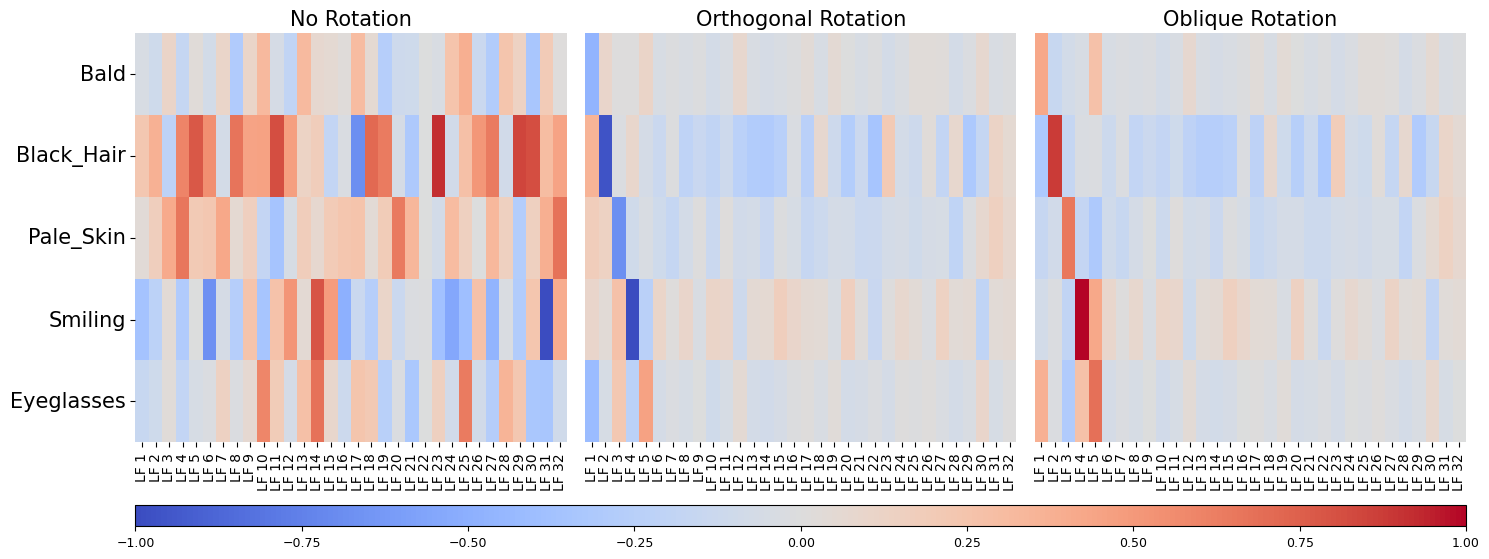

In [31]:
def compute_correlation_matrix(y_attr_list, Z):
    num_attrs = len(y_attr_list)
    latent_dim = Z.shape[1]
    corr_matrix = np.zeros((num_attrs, latent_dim))
    for i, y in enumerate(y_attr_list):
        for j in range(latent_dim):
            corr, _ = pointbiserialr(y, Z[:, j])
            corr_matrix[i, j] = corr
    return corr_matrix

# Compute correlation matrices
corr_unrotated = compute_correlation_matrix(y_train_attr_list, Z_train)
corr_orth = compute_correlation_matrix(y_train_attr_list, Z_train_orth_rotated)
corr_obl = compute_correlation_matrix(y_train_attr_list, Z_train_obl_rotated)

fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[0.95, 0.05]) 

# Heatmap axes
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

heatmap_data = [
    ("No Rotation", corr_unrotated),
    ("Orthogonal Rotation", corr_orth),
    ("Oblique Rotation", corr_obl)
]

ytick_labels = [f'{selected_attributes[i]}' for i in range(len(y_train_attr_list))]

for ax, (title, corr_matrix) in zip(axes, heatmap_data):
    sns.heatmap(
        corr_matrix, cmap='coolwarm', center=0, ax=ax,
        xticklabels=[f'LF {i+1}' for i in range(corr_matrix.shape[1])],
        yticklabels=(ax == axes[0]),  # Only show yticklabels for the first plot
        cbar=False
    )
    ax.set_title(title, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    if ax == axes[0]:
        ax.set_yticks(np.arange(len(ytick_labels)) + 0.5)
        ax.set_yticklabels(ytick_labels, rotation=0, fontsize=15)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

# Legend
cbar_ax = fig.add_subplot(gs[1, :])
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('correlation_heatmap.jpg')
plt.show()

# Generating reconstructed images from latent space without rotation for training DNN classifers

In [ ]:
# Reverting the weight of the decoder without rotation
decoder.layers[1].set_weights([W, bias])

batch_size = 32
reconstructed_images_train = []

for batch in train_dataset:
    batch_reconstructed = autoencoder.predict(batch)
    reconstructed_images_train.append(batch_reconstructed)
    clear_output(wait=True)

# Combine all batches into one array
reconstructed_images_train = np.concatenate(reconstructed_images_train, axis=0)
reconstructed_images_val = autoencoder.predict(val_dataset)

np.save('reconstructed_images_train.npy', reconstructed_images_train)
np.save('reconstructed_images_val.npy', reconstructed_images_val)

del reconstructed_images_train, reconstructed_images_val
import gc
gc.collect()

# Creating tensorFlow datasets from numpy arrays using generators for efficient data loading

In [9]:
reconstructed_images_train = np.load('/kaggle/working/reconstructed_images_train.npy', mmap_mode='r')
reconstructed_images_val = np.load('/kaggle/working/reconstructed_images_val.npy', mmap_mode='r')

batch_size = 32

# Create a generator function that yields data in batches
def data_generator_train():
    for i in range(0, len(reconstructed_images_train), batch_size):
        yield reconstructed_images_train[i:i+batch_size]

# Convert the generator to a tf.data.Dataset
reconstructed_images_train_dataset = tf.data.Dataset.from_generator(
    data_generator_train, 
    output_signature=tf.TensorSpec(shape=(None, 64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)


def data_generator_val():
    for i in range(0, len(reconstructed_images_val), batch_size):
        yield reconstructed_images_val[i:i+batch_size]

reconstructed_images_val_dataset = tf.data.Dataset.from_generator(
    data_generator_val, 
    output_signature=tf.TensorSpec(shape=(None, 64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)

# Combining reconstructed images with attribute labels (This block needs to be changed and executed before training a DNN classifier for a particular attribute)

In [ ]:
# Uncomment the code for a particular attribute and comment out the rest

reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[0]).batch(32))) 
reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[0]).batch(32)))

#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[1]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[1]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[2]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[2]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[3]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[3]).batch(32)))
#reconstructed_dataset_with_labels_train = tf.data.Dataset.zip((reconstructed_images_train_dataset, tf.data.Dataset.from_tensor_slices(y_train_attr_list[4]).batch(32))) 
#reconstructed_dataset_with_labels_val = tf.data.Dataset.zip((reconstructed_images_val_dataset, tf.data.Dataset.from_tensor_slices(y_val_attr_list[4]).batch(32)))

reconstructed_dataset_with_labels_train = reconstructed_dataset_with_labels_train.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
reconstructed_dataset_with_labels_val = reconstructed_dataset_with_labels_val.prefetch(tf.data.AUTOTUNE)

# DNN classifier to predict presence of attribute in reconstructed images

In [42]:
def build_probability_model(input_shape=(64,64,3)):
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),  # 16 filters
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Training the DNN classifer (Train for each attribute separately)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = build_probability_model()
model.fit(reconstructed_dataset_with_labels_train, epochs=30, validation_data=reconstructed_dataset_with_labels_val)

Epoch 1/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9441 - loss: 0.1868 - val_accuracy: 0.9485 - val_loss: 0.1742
Epoch 2/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9515 - loss: 0.1628 - val_accuracy: 0.9495 - val_loss: 0.1669
Epoch 3/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9530 - loss: 0.1576 - val_accuracy: 0.9495 - val_loss: 0.1642
Epoch 4/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9530 - loss: 0.1575 - val_accuracy: 0.9503 - val_loss: 0.1673
Epoch 5/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9529 - loss: 0.1558 - val_accuracy: 0.9502 - val_loss: 0.1633
Epoch 6/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9529 - loss: 0.1549 - val_accuracy: 0.9505 - val_loss: 0.1627
Epoch 7/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9535 - loss: 0.1530 - val_accuracy: 0.9502 - val_loss: 0.1637
Epoch 8/30
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9541 - loss: 0

# Saving the DNN classifier

In [44]:
model.save('model.keras')

# Loading saved DNN classifiers

In [4]:
model_paths = [
    '/kaggle/input/attribute-predict-models/bald_attribute_predict_model_no_rot_epoch30_CAE.keras',
    '/kaggle/input/attribute-predict-models/black_hair_attribute_predict_model_no_rot_epoch30_CAE.keras',
    '/kaggle/input/attribute-predict-models/pale_skin_attribute_predict_model_no_rot_epoch30_CAE.keras',
    '/kaggle/input/attribute-predict-models/smiling_attribute_predict_model_no_rot_epoch30_CAE.keras',
    '/kaggle/input/attribute-predict-models/eyeglasses_attribute_predict_model_no_rot_epoch30_CAE.keras'
]
models = [tf.keras.models.load_model(path) for path in model_paths]

# Loading and preprocessing the test dataset

In [26]:
test_files = partition_df[(partition_df['partition'] == 1)]['image_id'].tolist()

test_files = [os.path.join(img_dir, img_id) for img_id in test_files]

# Creating TensorFlow datasets for training and testing
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

y_test_attr_list = []

for attr in selected_attributes:
    y_test_attr = ((df[(df['partition'] == 1)][attr][:19840] + 1)/2).astype(int)
    y_test_attr_list.append(y_test_attr)

# Probabilities for presence of attributes in reconstructed images generated from latent space without rotation and manipulation (Baseline)

In [11]:
reconstructed_images_test = autoencoder.predict(test_dataset)

batch_size = 32
def data_generator_test():
    for i in range(0, len(reconstructed_images_test), batch_size):
        yield reconstructed_images_test[i:i+batch_size]

reconstructed_images_test_dataset = tf.data.Dataset.from_generator(
    data_generator_test, 
    output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
).prefetch(tf.data.AUTOTUNE)


baseline_predictions = [model.predict(reconstructed_images_test_dataset) for model in models]

620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Probabilities for presence of attributes in reconstructed images generated from orthogonally rotated latent space with specific dimension manipulation

In [28]:
Z_test = encoder.predict(test_dataset)
Z_test_orth_rotated = Z_test @ R

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])
orthogonal_predictions = []
j=0

for model in models:
    Z_test_modified = np.copy(Z_test_orth_rotated)
    corr, _ = pointbiserialr(y_test_attr_list[j], Z_test_orth_rotated[:, j])
    
    if corr > 0:
        avg_percentile = np.abs((np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    else:
        avg_percentile = -1.0 * np.abs((np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_orth_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    
        
    Z_test_modified[:,j] = avg_percentile
    j = j + 1
    reconstructed_images_mod_test = decoder.predict(Z_test_modified)

    batch_size = 32
    def data_generator_mod_test():
        for i in range(0, len(reconstructed_images_mod_test), batch_size):
            yield reconstructed_images_mod_test[i:i+batch_size]
    
    reconstructed_images_orth_test_dataset = tf.data.Dataset.from_generator(
        data_generator_mod_test, 
        output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
    ).prefetch(tf.data.AUTOTUNE)

    predictions = model.predict(reconstructed_images_orth_test_dataset)
    orthogonal_predictions.append(predictions)

620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Probabilities for presence of attributes in reconstructed images generated from obliquely rotated latent space with specific dimension manipulation

In [29]:
Z_test = encoder.predict(test_dataset)
Z_test_obl_rotated = Z_test @ R_prime

# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

oblique_predictions = []
j=0

for model in models:
    Z_test_modified = np.copy(Z_test_obl_rotated)
    corr, _ = pointbiserialr(y_test_attr_list[j], Z_test_obl_rotated[:, j])
    
    if corr > 0:
        avg_percentile = np.abs((np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    else:
        avg_percentile = -1.0 * np.abs((np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 0)[0]][:,j],10) + 
                           np.percentile(Z_test_obl_rotated[np.where(y_test_attr_list[j] == 1)[0]][:,j],90))/2.0)
    
        
    Z_test_modified[:,j] = avg_percentile
    j = j + 1
    reconstructed_images_mod_test = decoder.predict(Z_test_modified)

    batch_size = 32
    def data_generator_mod_test():
        for i in range(0, len(reconstructed_images_mod_test), batch_size):
            yield reconstructed_images_mod_test[i:i+batch_size]
    
    reconstructed_images_obl_test_dataset = tf.data.Dataset.from_generator(
        data_generator_mod_test, 
        output_signature=tf.TensorSpec(shape=(None,64,64,3), dtype=tf.float32)
    ).prefetch(tf.data.AUTOTUNE)

    predictions = model.predict(reconstructed_images_obl_test_dataset)
    oblique_predictions.append(predictions)

620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Plotting all probabilites

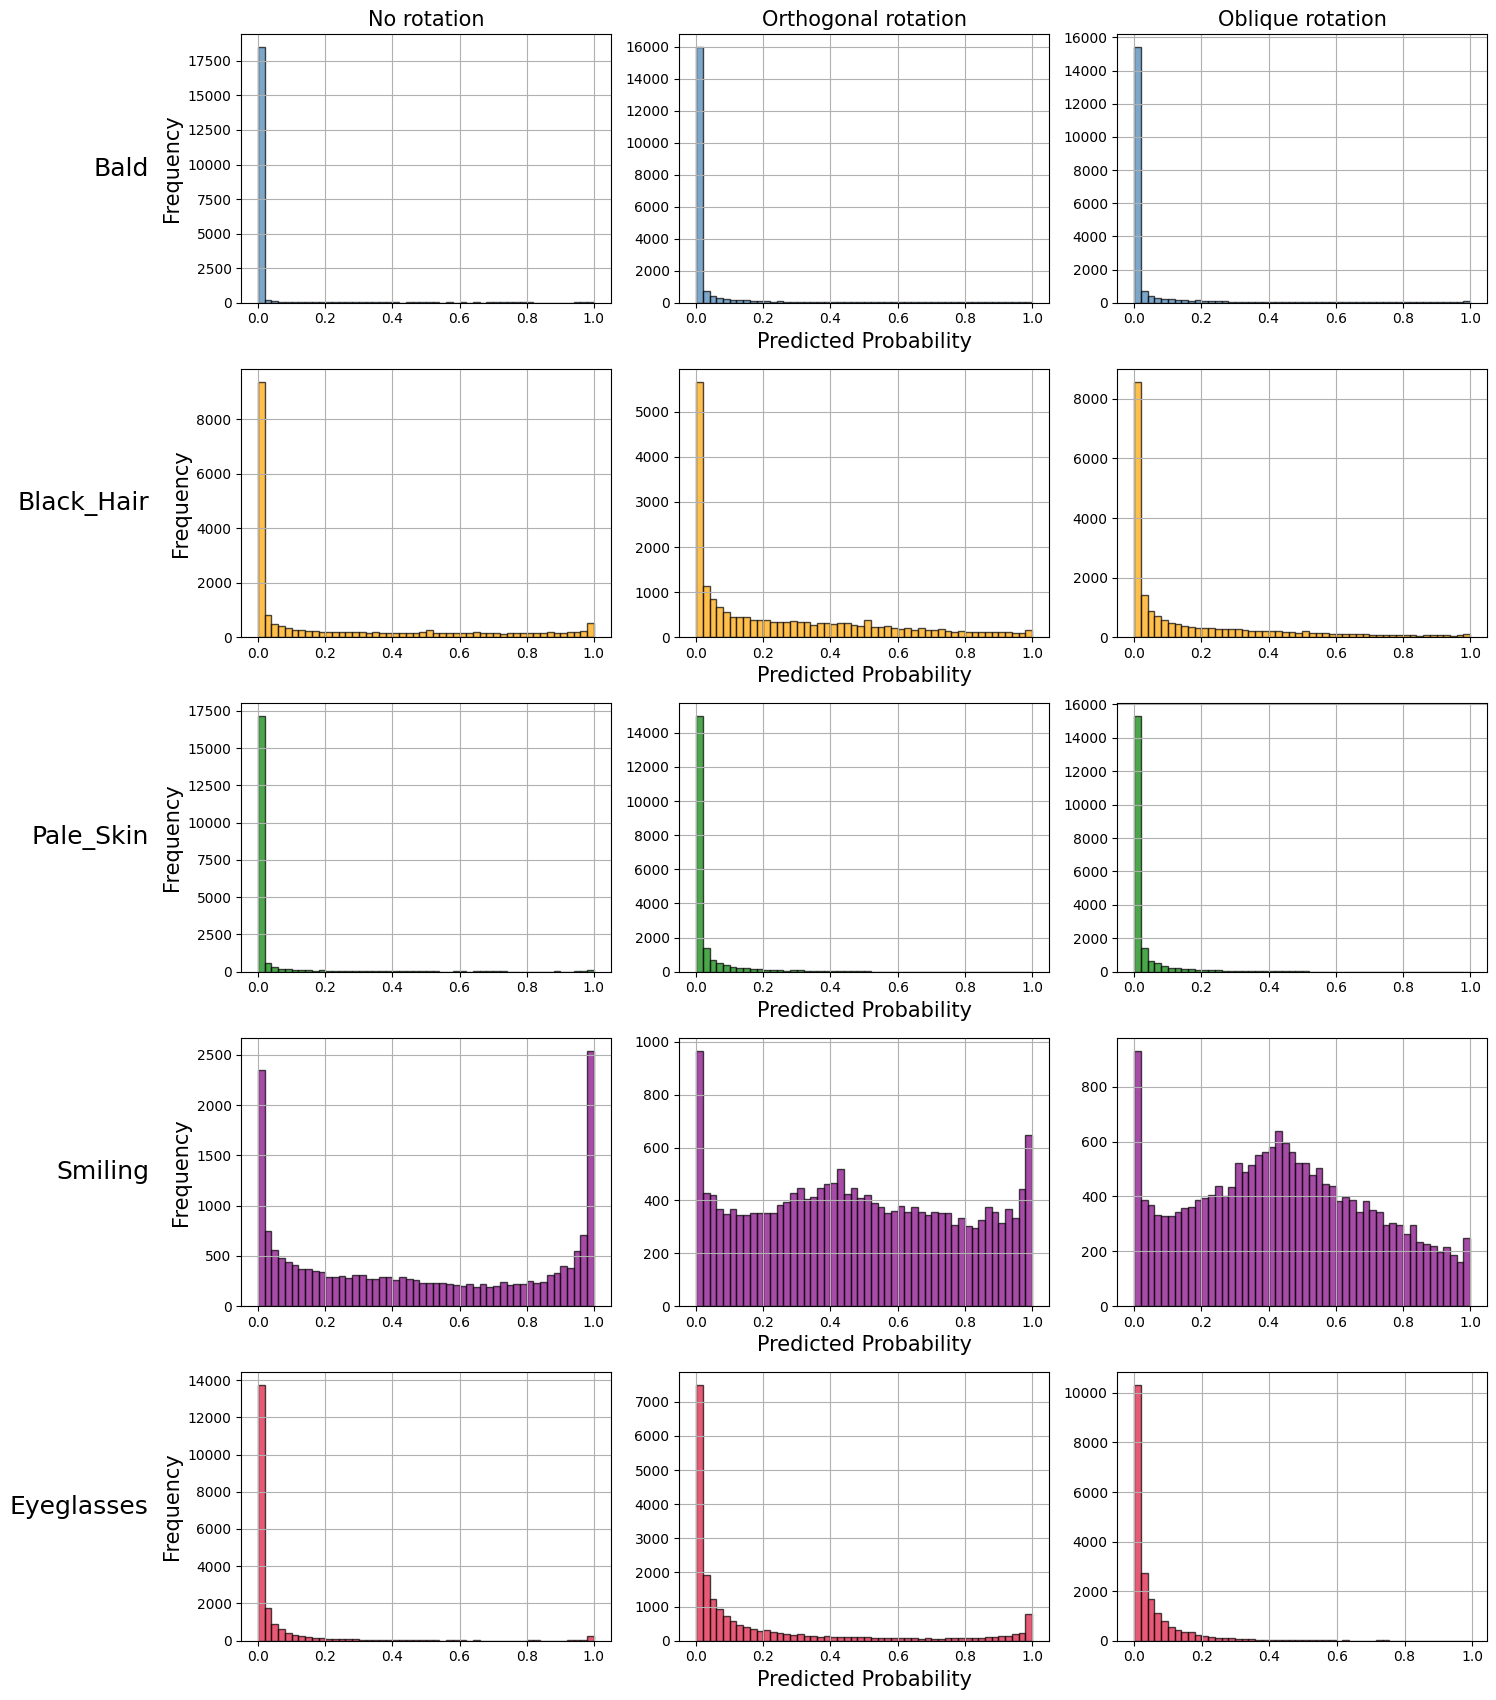

In [32]:
colour = ['steelblue', 'orange', 'green', 'purple', 'crimson']

attributes = []
for i in range(len(selected_attributes)):
    attributes.append((selected_attributes[i],baseline_predictions[i], orthogonal_predictions[i], oblique_predictions[i], colour[i]))

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 18), sharey=False)

plot_titles = ['No rotation', 'Orthogonal rotation', 'Oblique rotation']

for row_idx, (attr_name, baseline, rotated, oblique, color) in enumerate(attributes):
    data_list = [baseline, rotated, oblique]
    for col_idx, (data, title) in enumerate(zip(data_list, plot_titles)):
        ax = axes[row_idx, col_idx]
        ax.hist(data.flatten(), bins=50, color=color, alpha=0.7, edgecolor='black')
        if col_idx == 0:
            ax.set_ylabel('Frequency', fontsize=15)
        if row_idx == 0:
            ax.set_title(title, fontsize=15)
        if col_idx == 1:
            ax.set_xlabel('Predicted Probability', fontsize=15)
        ax.grid(True)
        if col_idx == 0:
            ax.text(-0.25, 0.5, attr_name, va='center', ha='right', rotation=0,
        transform=ax.transAxes, fontsize=18)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Attribute_classification_CAE.jpg')
plt.show()